# Setup noise source distribution

In [1]:
import numpy as np
from obspy.geodetics import gps2dist_azimuth
from obspy.signal.invsim import cosine_taper
import matplotlib.pyplot as plt
import h5py
from noisi import WaveField
import json
from glob import glob
import os
from scipy.fftpack import next_fast_len
%matplotlib inline

NOISI toolkit
Python version: 3.6.5 | packaged by conda-forge | (default, Apr  6 2018, 13:44:09) 
[GCC 4.2.1 Compatible Apple LLVM 6.1.0 (clang-602.0.53)]
mpi4py version: 3.0.0
/Users/jigel/noisi/noisi


In [8]:
######################
# Define the bases!
######################
# geography - Add anything else than a homogeneous distribution by setting to "True" the following:
only_ocean = False
gaussian_blobs = False
params_gaussian_blobs = [{'center':(0.,0.),'sigma_radius_m':500000.,'rel_weight':2.}]

#spectra
params_gaussian_spectra = [{'central_freq':0.005,'sigma_freq':0.01,'weight':0.01}]
                          #{'central_freq':0.075,'sigma_freq':0.1,'weight':10.}]

In [9]:
grd  = np.load('../sourcegrid.npy')
ntraces = np.shape(grd)[-1]
print(ntraces)

68199


In [10]:
config = json.load(open('../config.json'))    
source_config = json.load(open('./source_config.json'))
# Find the sampling rate and the nr. of points in synthetic seismograms
synthetics_path = config['wavefield_path']

if source_config['preprocess_do']:
    ext = '*.h5_proc'
else:
    ext = '*.h5'
print(ext)
wfs = glob(os.path.join(synthetics_path,ext))
with WaveField(wfs[0]) as wf:
    df = wf.stats['Fs']
    nt = wf.stats['nt']
    # The number of points for the fft is larger due to zeropadding --> apparent higher frequency sampling\n",
    n = next_fast_len(2*nt-1)
    print(df,nt,n)
    freq = np.fft.rfftfreq(n,d=1./df)
    print(np.min(freq),np.max(freq))
    taper = cosine_taper(len(freq),0.05)
    print(len(freq))

*.h5
<HDF5 file "CH.FIESA..MXZ.h5" (mode r)>
1.0 1703 3456
0.0 0.5
1729


In [27]:
def get_distance(grid,location):
    def f(lat,lon,location):
        return abs(gps2dist_azimuth(lat,lon,location[0],location[1])[0])
    dist = np.array([f(lat,lon,location) for lat,lon in zip(grid[1],grid[0])])
    return dist
    # Use cartopy to figure out where ocean is
def get_ocean_mask():
    print('Getting ocean mask...')
    from noisi.util.cartopy_is_land import is_land
    print("Latitude {}--{},\n\
    Longitude {}--{}".format(
    round(np.min(grd[1]),2),
    round(np.max(grd[1]),2),
    round(np.min(grd[0]),2),
    round(np.max(grd[0]),2)))
    ocean_mask = [not is_land(lon,lat) for (lon,lat) in grd.transpose()]
    
    return np.array(ocean_mask)




In [28]:
#########################
# Create the source distr
#########################

# geography
num_bases = 1
if gaussian_blobs:
    num_bases += len(params_gaussian_blobs)

basis1 = np.zeros((num_bases,ntraces))
print(np.shape(basis1))
# homogeneous layer
basis1[0,:] = np.ones(ntraces) 
if only_ocean:
    basis1[0,:] *= np.array(get_ocean_mask()).astype(int)
    # superimposed Gaussian blob(s)
if gaussian_blobs:
    i = 1
    for blob in params_gaussian_blobs:
        dist = get_distance(grd,blob['center'])
        basis1[i,:] = np.exp(-(dist)**2/(2*blob['sigma_radius_m']**2))
        i+=1

        
# spectra
basis2 = np.zeros((len(params_gaussian_spectra),len(freq)))
# 'sort of hum gaussian'
i = 0
for spec in params_gaussian_spectra:
    basis2[i,:] = taper*np.exp(-(freq-spec['central_freq'])**2/(2*spec['sigma_freq']**2))
# This normalization means different integrals...
    basis2[i,:] /= np.max(np.abs(basis2[0,:]))
    i+=1

print(np.shape(basis1))

(1, 68199)
Getting ocean mask...
Latitude -89.01--89.09,
Longitude -179.99--179.99
(1, 68199)


In [29]:
######################
# set the weights
#####################
# geography
weights1 = np.ones(np.shape(basis1)[0])
print(np.shape(weights1))
if gaussian_blobs:
    i = 1
    for blob in params_gaussian_blobs:
        weights1[i] = blob['rel_weight']
        i+=1
#print weights1
# spectra --- much harder to assign manually, since we need weights for every location. just assigning ones.\n",
weights2 = np.ones((np.shape(grd)[-1],np.shape(basis2)[0]))
i=0
for spec in params_gaussian_spectra:
    weights2[:,i] *= spec['weight']
#print weights2

(1,)


In [30]:
from noisi.util import plot

max. value on map: 1


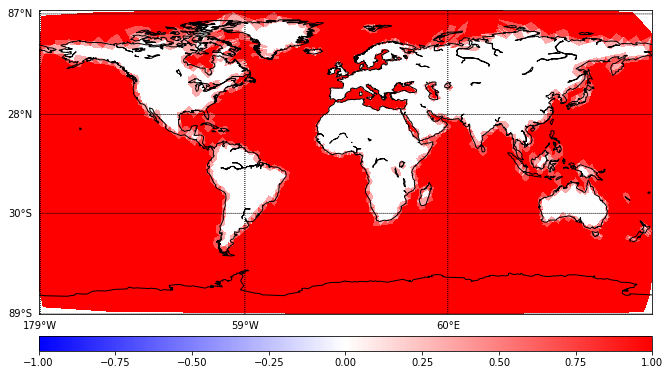

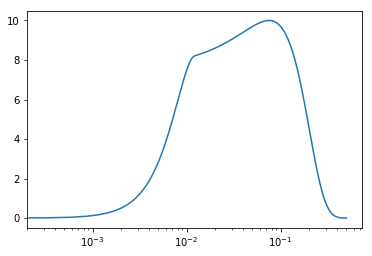

In [31]:
distr = np.dot(weights1,basis1)
plot.plot_grid(grd[0],grd[1],distr,mode='srcdots')

plt.semilogx(freq,np.dot(weights2[0,:],basis2))
plt.show()

## Voronoi Cell Surface Area

New: The voronoi cells are computed for the given grid and the surface areas are calculated. These are then added to the sourcemodel in surf_area. 

If the grid is ocean only, the full grid will be computed since the points at the sea shore will otherwise have voronoi cells that are too big. Afterwards the voronoi cells and gridpoints on land are removed again.

In [ ]:
# Set config["voronoi_surface_area"]: true if voronoi surface areas are to be calculated
# Otherwise all surface areas will be set to one. 

if config['voronoi_surface_area']:
    from noisi.util.voronoi_surface_area import get_voronoi_surface_area

    if only_ocean:
        from noisi.scripts.source_grid_gauss import gauss_grid
        import cartopy.crs as ccrs
        
        n_grids = np.size(config['gauss_sigma'])
          
        if n_grids == 1:
            only_ocean_false = False
        else:
            only_ocean_false = [False]*n_grids
            
        plot_true = [False]*n_grids

        # compute full grid with only_ocean = False
        grd_full = gauss_grid(config['gauss_sigma'],config['gauss_beta'],config['gauss_phi_ini'],config['gauss_phi_max'],
                      config['gauss_lat_0'],config['gauss_lon_0'],config['gauss_n'],config['gauss_gamma'],
                      plot=plot_true,dense_antipole=config['gauss_dense_antipole'],
                      only_ocean=only_ocean_false)
        
        # Calculate voronoi cells for the whole grid
        grd, voronoi_areas = get_voronoi_surface_area(grd_full)
        
        # Plot
        plt.figure(figsize=(25,10))
        ax = plt.axes(projection=ccrs.Mollweide())
        ax.coastlines()
        plt.scatter(grd[0],grd[1],s=1,c='k',transform=ccrs.Geodetic())
        plt.title('Intial Gauss Grid with all gridpoints')
        plt.show() 

        # Remove points on land again
        from noisi.util.cartopy_is_land import is_land
        grid_onlyocean_lon = []
        grid_onlyocean_lat = []
        voronoi_areas_onlyocean = []

        for i in range(0,np.size(grd[0])):
            if not is_land(grd[0][i],grd[1][i]):
                grid_onlyocean_lon.append(grd[0][i])
                grid_onlyocean_lat.append(grd[1][i])
                voronoi_areas_onlyocean.append(voronoi_areas[i])
            else:
                continue
         
        plt.figure(figsize=(25,10))
        ax = plt.axes(projection=ccrs.Mollweide())
        ax.coastlines()
        plt.scatter(grid_onlyocean_lon,grid_onlyocean_lat,s=1,c=voronoi_areas_onlyocean,transform=ccrs.Geodetic(),cmap=plt.get_cmap('seismic_r'))
        plt.title('Final Gauss Grid with gridpoints removed')
        plt.colorbar()
        plt.show() 
        
        print('Gridpoints and voronoi cells on land removed.')
        grd = np.asarray([grid_onlyocean_lon,grid_onlyocean_lat])
        surf_areas = np.asarray(voronoi_areas_onlyocean)
        print('Final number of gridpoints:', int(np.size(grd)/2))

    else:
        grd, voronoi_areas = get_voronoi_surface_area(grd)
        surf_areas = voronoi_areas
else:
    surf_areas = np.ones(ntraces)


## Export

In [12]:
# Save to an hdf5 file
sourcepath = ('./')
print(len(basis2[0,:]))

with h5py.File('sourcemodel.h5','w') as fh:
    fh.create_dataset('coordinates',data=grd.astype(np.float32))
    fh.create_dataset('frequencies',data=freq.astype(np.float32))
    fh.create_dataset('distr_basis',data=basis1.astype(np.float32))
    fh.create_dataset('distr_weights',data=weights1.astype(np.float32))
    fh.create_dataset('spect_basis',data=basis2.astype(np.float32))
    fh.create_dataset('spect_weights',data=weights2.astype(np.float32))
    fh.create_dataset('surf_areas',data=surf_areas.astype(np.float32))
    
    
# Save sourcemodel as starting_model

with h5py.File(os.path.join(sourcepath,'step_0','starting_model.h5'),'w') as fh:
    fh.create_dataset('coordinates',data=grd.astype(np.float32))
    fh.create_dataset('frequencies',data=freq.astype(np.float32))
    fh.create_dataset('distr_basis',data=basis1.astype(np.float32))
    fh.create_dataset('distr_weights',data=weights1.astype(np.float32))
    fh.create_dataset('spect_basis',data=basis2.astype(np.float32))
    fh.create_dataset('spect_weights',data=weights2.astype(np.float32))
    fh.create_dataset('surf_areas',data=surf_areas.astype(np.float32))


    
# Create base_model

basis1_b = np.ones(basis1.shape)
with h5py.File(os.path.join(sourcepath,'step_0','base_model.h5'),'w') as fh:
    fh.create_dataset('coordinates',data=grd.astype(np.float32))
    fh.create_dataset('frequencies',data=freq.astype(np.float32))
    fh.create_dataset('distr_basis',data=basis1_b.astype(np.float32))
    fh.create_dataset('distr_weights',data=weights1.astype(np.float32))
    fh.create_dataset('spect_basis',data=basis2.astype(np.float32))
    fh.create_dataset('surf_areas',data=surf_areas.astype(np.float32))



1729


In [13]:
ls

measr_config.json            source_config.json
observed_correlations/       sourcemodel.h5
setup_noisesource.ipynb      step_0/
setup_noisesource.py         wavefield_from_instaseis.py


In [14]:
# Copy jupyter notebooks from util to source folder
# import again in case only this cell is run

import shutil
from glob import glob
import os

path_util = ('../../noisi/jnotebks/')
ext = ('*.ipynb')
path_source = os.getcwd()
#print(path_source)

file_nb = glob(os.path.join(path_util,ext))
#print(file_nb)

for files in file_nb:
    if os.path.exists(os.path.join(path_source,os.path.basename(files))):
        print('Not copied: ' + os.path.basename(files))
        continue
    else:
        shutil.copy(files,path_source)
        print('Copied:  ' + os.path.basename(files))

Copied:  setup_gaussian_grid.ipynb
Copied:  plot_corr_sort_azimuth.ipynb
Copied:  test_gradient_consistency.ipynb
Copied:  precompute_1DGreen.ipynb
Copied:  plot_kernel_gradient.ipynb
Not copied: setup_noisesource.ipynb
Copied:  make_synthetic_data.ipynb
